In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from dateutil.relativedelta import *
import jetson_configs as jcfg

from src.ml_helpers.compile_ml_results import *


prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [2]:
split_date      = jcfg.train_test_split
horizon         = jcfg.horizon #1
admin_level     = jcfg.admin_level
current_month   = jcfg.current_month
experiment_name = jcfg.experiment_name

fpath = f"{admin_level}_lag{horizon}"

In [3]:
compile_ml_results(fpath)

# Import results

In [4]:
bl  = pd.read_csv(f"ml/output_data/{fpath}/results_baseline.csv",    index_col=[ 'region','date'], parse_dates=['date'])
ml  = pd.read_csv(f"ml/output_data/{fpath}/results_ml_compiled.csv", index_col=['region', 'date'], parse_dates=['date'])

## Label train/test

In [5]:
# Add an indicator for the dataset used 
ml['dataset'] = np.where(ml.index.get_level_values("date") <= pd.to_datetime(split_date), 'train', 'test')

In [6]:
#.apply(lambda x: x+ relativedelta(months=horizon))

## Merge them

In [7]:
compiled_df = bl.merge(ml, left_index=True, right_index=True, how='outer')

## Heuristically remove outliers

In [8]:
print("Replacements for being too low/high:")

for v in compiled_df.columns:
    if 'dataset' not in v and v!='features_date':
        
        if (compiled_df[compiled_df[v]<0].shape[0]>0) or  (compiled_df[compiled_df[v]>500000].shape[0]>0):
            print(f"{v:60s}", compiled_df[compiled_df[v]<0].shape[0], compiled_df[compiled_df[v]>500000].shape[0])
        
        # No negative arrivals
        compiled_df[v] = np.where(compiled_df[v]<0, 0, compiled_df[v])
        
        # No arrivals in excess of half a million
        compiled_df[v] = np.where(compiled_df[v]>500000, 500000, compiled_df[v])

Replacements for being too low/high:
predicted_Lasso_tscv_means_noyfill_noyhist                   478 0
predicted_Lasso_tscv_nomeans_noyfill_noyhist                 517 0
predicted_Lasso_tscv_nomeans_noyfill_yhist                   568 0
predicted_lstm_12_100_1layer                                 254 0
predicted_Perceptron_tscv_means_noyfill_noyhist              354 0
predicted_Perceptron_tscv_nomeans_noyfill_noyhist            396 0
predicted_Perceptron_tscv_nomeans_noyfill_yhist              411 0
predicted_Ridge_tscv_means_noyfill_noyhist                   397 0
predicted_Ridge_tscv_nomeans_noyfill_noyhist                 505 0
predicted_Ridge_tscv_nomeans_noyfill_yhist                   564 0


## Tidy column names

In [9]:
compiled_df.columns = [i.replace("predicted_","")   for i in compiled_df.columns]

In [10]:
# Round all predictions to whole numbers
# compiled_df = compiled_df.round(0)

## Export

In [11]:
compiled_df[[i for i in compiled_df.columns if 'model_' not in i]].to_csv(f"ml/output_data/master_{fpath}.csv")

In [12]:
# Note: some of the earlier models have missing values; a comparison between models using all observations is therefore not totally valid
#compiled_df[compiled_df.true.isna()==False].count()

# Plot

In [13]:
mean_arrivals = compiled_df.true.groupby(['region']).mean().astype(int)
regions       = compiled_df.index.get_level_values("region").unique()

In [14]:
compiled_df.columns = [i.replace("_"+experiment_name, "") for i in compiled_df.columns]

## Arrivals by region

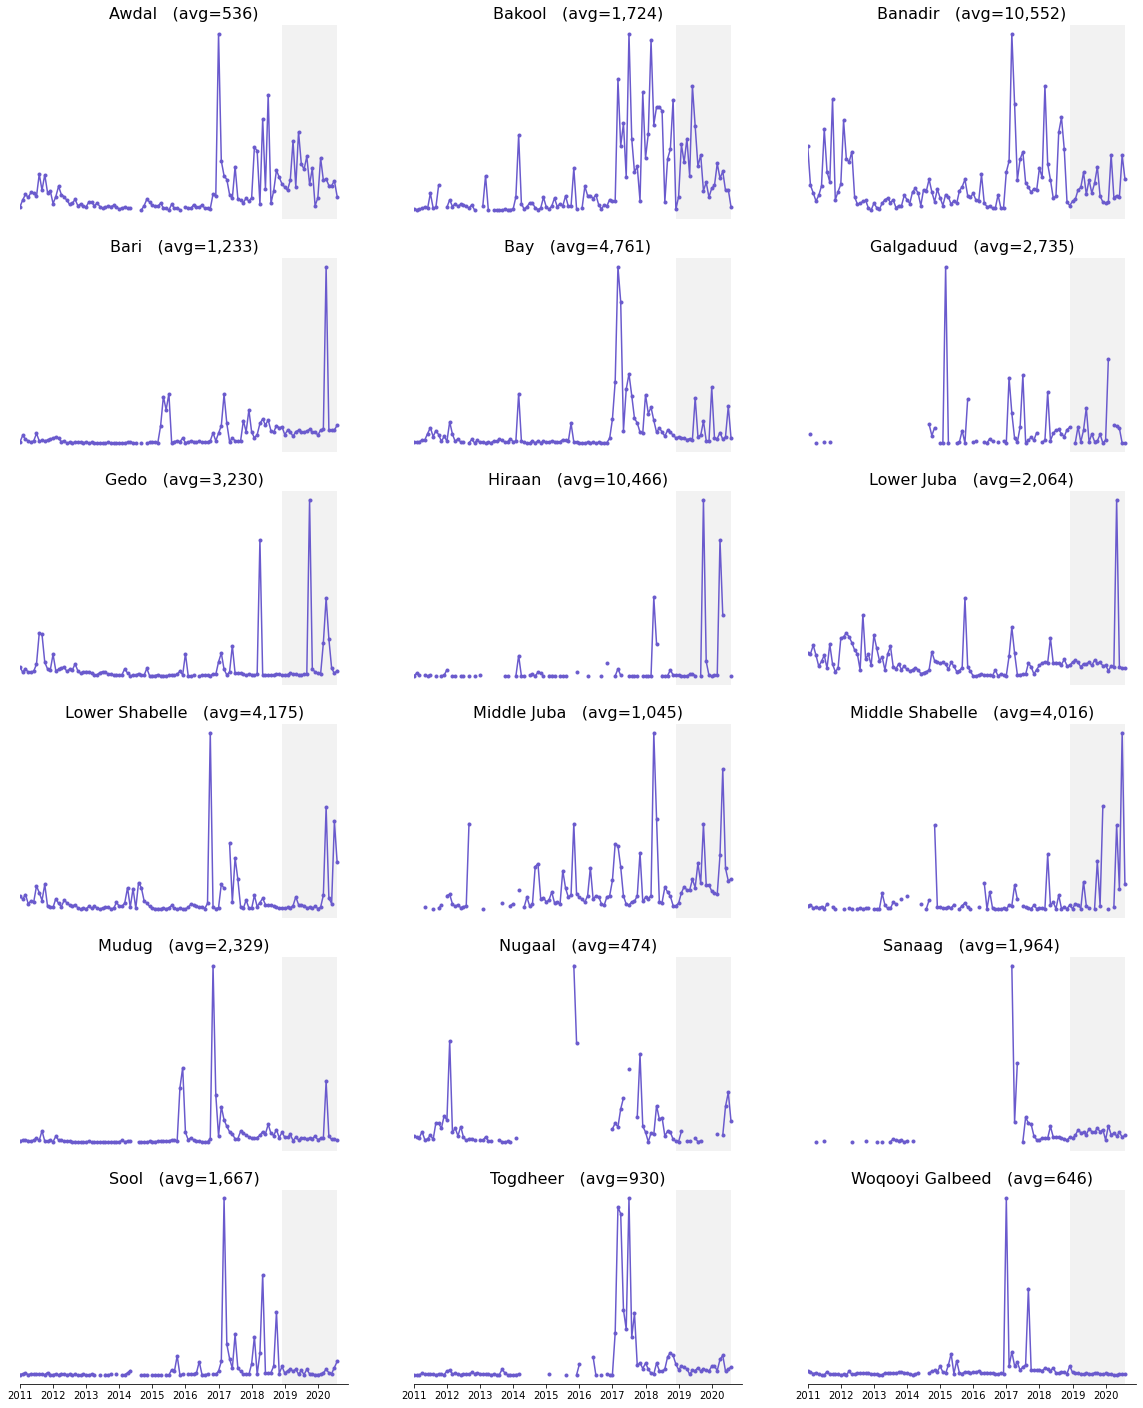

In [15]:
fig, ax = plt.subplots(6,3, figsize=[20,25], sharex=True)

plot_df = compiled_df['true'].unstack(level='region')
plot_df.plot(subplots=True, ax=ax, #logy=True, 
             color='slateblue', 
             marker=".", 
             legend=None)

'''
for c in ['Perceptron', 'lstm_12_100_1layer']: #, 'Adaboost']:
    
    if c=='Perceptron':
        alpha=0.5
        linestyle="-"
    else:
        alpha=1
        linestyle=":"
    plot_df = compiled_df[c].unstack(level='region')
    plot_df.plot(subplots=True, ax=ax, linestyle=linestyle, #logy=True, 
                 legend=None, alpha=alpha)
'''
for a in range(0,18):
    i = a//3
    j = a%3
    #ax[i][j].axis("Off")
    
    ax[i][j].set_xlabel("")
    
    # Keep only the axes at the bottom of the plot
    if i==5:
        ax[i][j].tick_params(axis='x', which='minor', bottom=False)
    else:
        ax[i][j].tick_params(axis='x', which='both', bottom=False)
        ax[i][j].spines["bottom"].set_visible(False)
    
    # Get rid of y axis
    ax[i][j].axes.get_yaxis().set_visible(False)
    
    # Get rid of the axis spines
    ax[i][j].spines["right"].set_visible(False)
    ax[i][j].spines["left"].set_visible(False)
    ax[i][j].spines["top"].set_visible(False)
    
    r = plot_df.columns[a] 
    ax[i][j].set_title(f"{r}   (avg={mean_arrivals.loc[r]:,})", fontsize=16)
    ax[i][j].axvspan(split_date, current_month+"-01", facecolor='darkgrey', alpha=0.15)
    
plt.savefig(f"figures/trends_{admin_level}_{horizon}.png", dpi=100, bbox_inches="tight")
plt.show()

## Predictions

In [16]:
compiled_df.rename(columns = {'lstm_12_100_1layer':'LSTM'}, inplace=True)

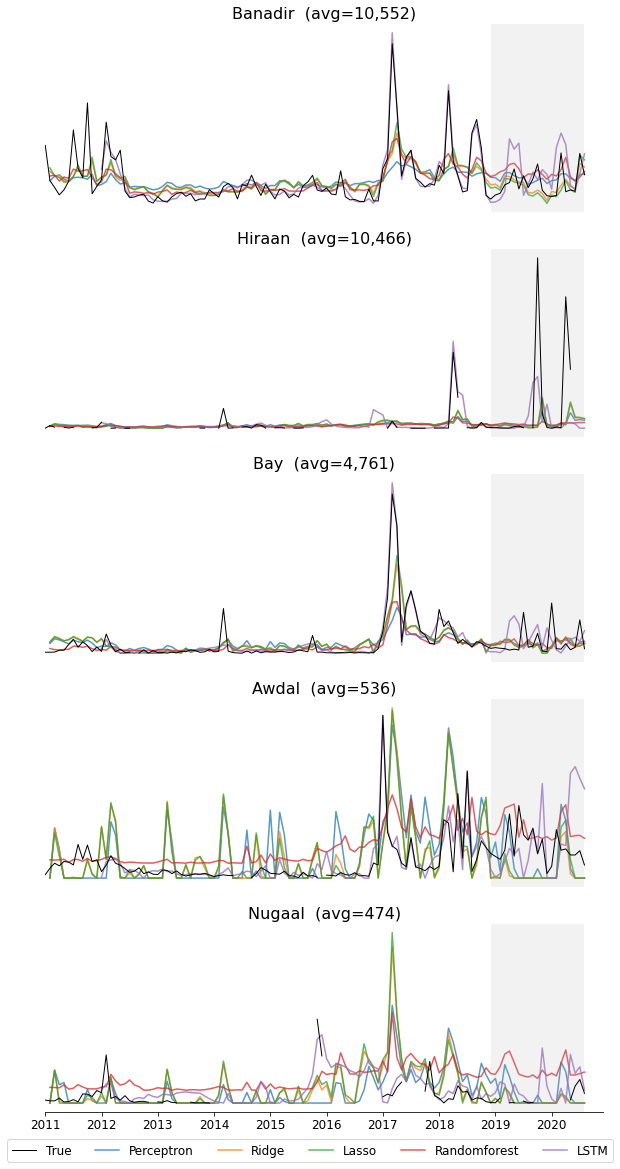

In [17]:
fig, ax = plt.subplots(5,1, figsize=[10,20], sharex=True)

model_list = ['Perceptron',  'Ridge', 'Lasso', 'Randomforest', 'LSTM'] #, 'LSTM'] # Adaboost', 'Decisiontree', 'Randomforest', 'Ridge'] #, 'Lasso',  'Randomforest',  ] #, 'lstm_12_100_1layer'] # 'lstm_12_100_1layer', 'Xgboost', 'Decisiontree', 
region_list = ['Banadir', 'Hiraan', 'Bay', 'Awdal', 'Nugaal'] #'Woqooyi Galbeed', 'Galgaduud', 'Middle Juba', 'Gedo', 'Bay']]
plot_df = compiled_df['true'].unstack(level='region')[region_list] 
plot_df.plot(subplots=True, ax=ax, #logy=True, 
             color='black', linewidth=1, #linestyle="--",
             legend=None, zorder=1)

i=0
for c in model_list: #, 'Adaboost']:
    
    plot_df = compiled_df[c].unstack(level='region')[region_list] 
    plot_df.plot(subplots=True, ax=ax, # linestyle=linestyle, #logy=True, 
                 legend=False, alpha=0.75, color = colors[i], zorder=0, fontsize=12)
    i+=1

for i in range(0,5):
    #ax[i][j].axis("Off")
    
    ax[i].set_xlabel("")
    
    # Keep only the axes at the bottom of the plot
    if i==4:
        ax[i].tick_params(axis='x', which='minor', bottom=False)
    else:
        ax[i].tick_params(axis='x', which='both', bottom=False)
        ax[i].spines["bottom"].set_visible(False)
    
    # Get rid of y axis
    ax[i].axes.get_yaxis().set_visible(False)
    
    # Get rid of the axis spines
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["left"].set_visible(False)
    ax[i].spines["top"].set_visible(False)
    
    r = plot_df.columns[i] 
    ax[i].set_title(f"{r}  (avg={mean_arrivals.loc[r]:,})", fontsize=16)
    ax[i].axvspan(split_date, current_month+"-01", facecolor='darkgrey', alpha=0.15, label='Test')


ax[4].legend(['True'] + model_list, loc='lower center', ncol=6, fontsize=12, bbox_to_anchor=[0.475,-.3])

plt.savefig(f"figures/predictions_{admin_level}_{horizon}.png", dpi=100, bbox_inches="tight")
plt.show()